In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import time
import numpy as np

In [2]:
#test train data split 

splitfolders.ratio("./data/natural_images/", output="output", seed=1337, ratio=(.8, .1,.1), group_prefix=None)

Copying files: 6899 files [01:05, 105.88 files/s]


In [3]:
#Define Transforms
transform = transforms.Compose(
    [transforms.Resize((150,150)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Hyper Parameters
batch_size = 8
learning_rate = 0.001

traindataset = datasets.ImageFolder('./output/train', transform=transform)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,shuffle=True)

valdataset = datasets.ImageFolder('./output/val', transform=transform)
valloader = torch.utils.data.DataLoader(valdataset, batch_size=batch_size, shuffle=True)

testdataset = datasets.ImageFolder('./output/val', transform=transform)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=True)



classes = ('Airplane','Car','Cat','Dog','Flower','Fruit','Motorbike','Person')

In [4]:
len(traindataset)

5516

In [5]:
len(valdataset)

686

In [6]:
len(testdataset)

686

In [7]:
print(traindataset.class_to_idx)

{'airplane': 0, 'car': 1, 'cat': 2, 'dog': 3, 'flower': 4, 'fruit': 5, 'motorbike': 6, 'person': 7}


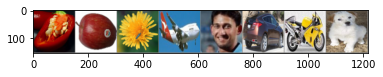

Flower Fruit Flower Airplane Person Car   Motorbike Dog  


In [8]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(7200, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #nn.Dropout(p=0.4)
        x = self.pool(F.relu(self.conv2(x)))
       # nn.Dropout(p=0.4)
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [10]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [11]:
def get_accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return round(correct/total,3)

Epoch [1/10], Step [690/690], Time taken:[123.484 seconds], Loss: 1.8950
Epoch [2/10], Step [690/690], Time taken:[87.75 seconds], Loss: 1.3830
Epoch [3/10], Step [690/690], Time taken:[88.288 seconds], Loss: 1.2350
Epoch [4/10], Step [690/690], Time taken:[94.495 seconds], Loss: 1.1870
Epoch [5/10], Step [690/690], Time taken:[94.863 seconds], Loss: 1.1260
Epoch [6/10], Step [690/690], Time taken:[86.373 seconds], Loss: 1.1040
Epoch [7/10], Step [690/690], Time taken:[94.0 seconds], Loss: 1.0800
Epoch [8/10], Step [690/690], Time taken:[85.614 seconds], Loss: 1.0560
Epoch [9/10], Step [690/690], Time taken:[86.583 seconds], Loss: 1.0540
Epoch [10/10], Step [690/690], Time taken:[88.848 seconds], Loss: 1.0470


NameError: name 'test_list' is not defined

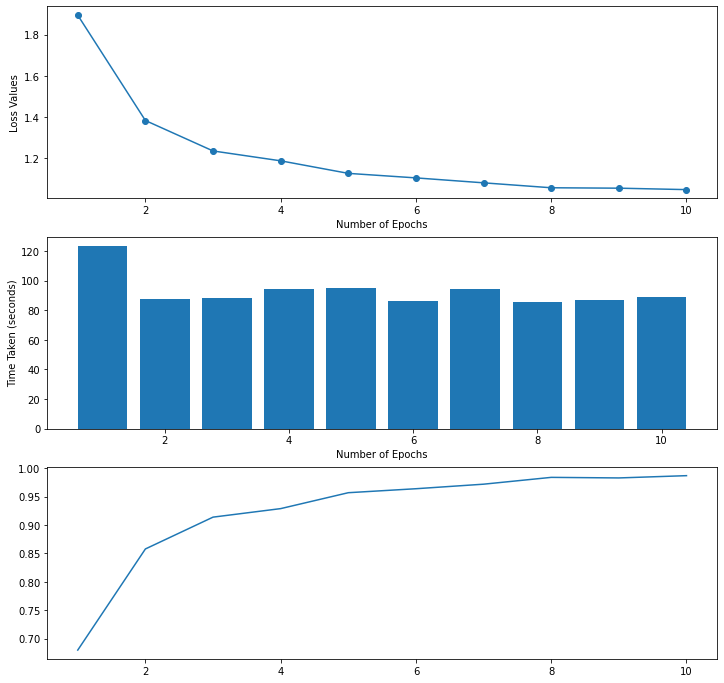

In [12]:
num_of_epochs = 10
loss_list = []
time_list = []
train_list = []
val_list = []
fig, axs = plt.subplots(3)
fig.set_figheight(12)
fig.set_figwidth(12)

for epoch in range(num_of_epochs):  # loop over the dataset multiple times
    epoch_start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()
        #for accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        correct+= (predicted == labels).sum().item()
        total+=labels.size(0)
    epoch_end_time = time.time()
    avg_running_loss = round(running_loss/i+1,3)
    time_taken = round(epoch_end_time - epoch_start_time,3)
    #plot purpose 
    loss_list.append(avg_running_loss)
    time_list.append(time_taken)
    train_list.append(round(correct/total,3))
    val_list.append(get_accuracy(valloader))
    
    # print statistics
    print (f'Epoch [{epoch+1}/{num_of_epochs}], Step [{i+1}/{len(trainloader)}], Time taken:[{time_taken} seconds], Loss: {avg_running_loss:.4f}')
    
x_values = np.arange(1,num_of_epochs+1)
axs[0].plot(x_values,loss_list,marker='o')
axs[0].set_xlabel("Number of Epochs")
axs[0].set_ylabel("Loss Values")
axs[1].bar(x_values,time_list)
axs[1].set_xlabel("Number of Epochs")
axs[1].set_ylabel("Time Taken (seconds)")
axs[2].plot(x_values,train_list , label = 'Train Accuracy')
axs[2].plot(x_values,val_list, label = 'Validation Accuracy')
axs[2].set_xlabel("Number of Epochs")
axs[2].set_ylabel("Accuracy")
axs[2].legend()
plt.show()
print('Finished Training')

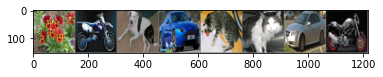

GroundTruth:  Flower Motorbike Dog   Car   Cat   Cat   Car   Motorbike


In [20]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [21]:
PATH = './flowers_net.pth'
torch.save(net.state_dict(), PATH)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  Flower Motorbike Dog   Car   Dog   Cat   Car   Motorbike


In [22]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Airplane is 95.8 %
Accuracy for class: Car   is 86.5 %
Accuracy for class: Cat   is 60.2 %
Accuracy for class: Dog   is 58.6 %
Accuracy for class: Flower is 86.9 %
Accuracy for class: Fruit is 100.0 %
Accuracy for class: Motorbike is 100.0 %
Accuracy for class: Person is 100.0 %


In [25]:
print(f'''Average test accuracy of the model is {get_accuracy(testloader)*100}%''')

Average test accuracy of the model is 86.7%
